In [2]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cell2location
import scvi
import os
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
import seaborn as sns
import time
import gc
gc.collect()


0

In [3]:
parent_path = os.path.dirname(os.getcwd())
cellcount = os.path.join(parent_path, "datasets", "SeqFISH+", "cellcount_SeqFISH_10000.csv")
sp_data = os.path.join(parent_path, "datasets", "SeqFISH+", "stdata_SeqFISH_10000.csv")
celltype = os.path.join(parent_path, "datasets", "SeqFISH+", "cell_type_SeqFISH.csv")

In [4]:
start_time = time.time()
adata_ref = sc.read_csv(cellcount)
df_celltype = pd.read_csv(celltype, header=0, index_col=0)
df_celltype.index = adata_ref.obs.index
adata_ref.obs['Subset'] = df_celltype

# Get 'Method'
adata_ref.obs['Method'] = '3GEX'

# Get 'Sample'
adata_ref.obs['Sample'] = adata_ref.obs_names
adata_ref.obs['Sample'] = adata_ref.obs['Sample'].apply(lambda x: x[0:4])

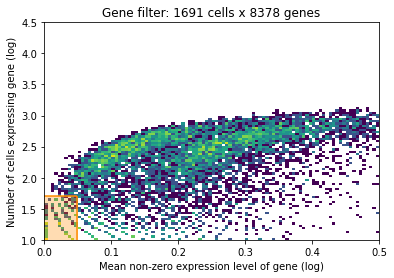

In [5]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
# 5, 0.03, 1.12

# In our case, a few genes are cut
adata_ref = adata_ref[:, selected].copy()

In [6]:
scvi.data.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='Sample',
                        # cell type, covariate used for constructing signatures
                        labels_key='Subset',
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        categorical_covariate_keys=['Method']
                       )
scvi.data.view_anndata_setup(adata_ref)

INFO     Using batches from adata.obs["Sample"]                                              
INFO     Using labels from adata.obs["Subset"]                                               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 1691 cells, 8378 vars, 1 batches, 
         6 labels, and 0 proteins. Also registered 1 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


Anndata setup with scvi-tools version 0.13.0.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 1691  │
│             Vars             │ 8378  │
│            Labels            │   6   │
│           Batches            │   1   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   1   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

                    SCVI Data Registry                    
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃          scvi-tools Location           ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │                adata.X                 │
│ batch_indices │        adata.obs['_scvi_batch']        │
│ local_l_mean  │    adata.obs['_scvi_local_l_mean']     │
│  local_l_var  │     adata.obs['_scvi_local_l_var']     │
│    labels     │       adata.obs['_scvi_labels']        │
│   cat_covs    │ adata.obsm['_scvi_extra_categoricals'] │
└───────────────┴────────────────────────────────────────┘

                     Label Categories                     
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Subset'] │    Olig    │          0          │
│                     │ astrocytes │          1          │
│                     │  eNeuron   │          2          │
│                     │ endo_mural │          3          │
│                     │  iNeuron   │          4          │
│                     │ microglia  │          5          │
└─────────────────────┴────────────┴─────────────────────┘

                     Batch Categories                     
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Sample'] │    1772    │          0          │
└─────────────────────┴────────────┴─────────────────────┘

               Extra Categorical Variables                
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Method'] │    3GEX    │          0          │
│                     │            │                     │
└─────────────────────┴────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/home/lih0n/anaconda3/envs/cellpymc/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 250/250: 100%|███████████████████████████████████████████████| 250/250 [01:12<00:00,  3.46it/s, v_num=1, elbo_train=9.73e+6]


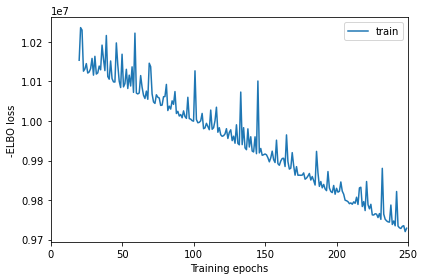

In [7]:
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# Use all data for training (validation not implemented yet, train_size=1)
mod.train(max_epochs=250, batch_size=2500, train_size=1, lr=0.002, use_gpu=True)

# plot ELBO loss history during training, removing first 20 epochs from the plot
mod.plot_history(20)

In [8]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Results saving folder
ref_run_name = f'./results/analysis/reference_signatures'

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

Sampling global variables, sample: 100%|████████████████████████████████████████████████████████| 999/999 [00:11<00:00, 89.78it/s]


/home/lih0n/anaconda3/envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
... storing 'Subset' as categorical
/home/lih0n/anaconda3/envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
... storing 'Method' as categorical
/home/lih0n/anaconda3/envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
... storing 'Sample' a

'./results/analysis/reference_signatures/sc.h5ad'

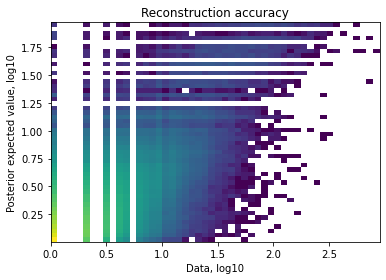

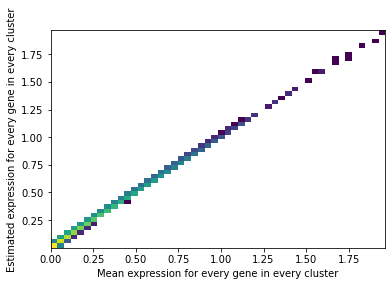

In [9]:
# First plot: Reconstruction accuracy to assess if there are any issues with inference
# Second plot: When this plot is very different from a diagonal plot (e.g. very low values on Y-axis, density everywhere) it indicates problems with signature estimation.
mod.plot_QC()

In [10]:
# Export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

# Note that the column names are cell types, the row names are gene names, in the original code
# the authors use ENSEMBL as names instead of raw gene names

,Olig,astrocytes,eNeuron,endo_mural,iNeuron
Tshz1,0.358432,0.410676,0.852205,0.486135,1.525731
Fnbp1l,0.316208,0.472146,2.710134,0.805485,2.863626
Adamts15,0.023195,0.016997,0.035139,0.106113,0.313943
Cldn12,0.279235,0.327061,0.708267,0.132647,0.626588
Rxfp1,0.013796,0.000165,0.074276,0.015362,0.450810


In [11]:
adata_vis = sc.read_csv(sp_data)
adata_vis.obs['sample'] = 'pseudo_st' # Since it is manually generated

In [12]:
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

In [13]:
scvi.data.setup_anndata(adata=adata_vis, batch_key="sample")
scvi.data.view_anndata_setup(adata_vis)

INFO     Using batches from adata.obs["sample"]                                              
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 71 cells, 8378 vars, 1 batches, 1 
         labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra  
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


Anndata setup with scvi-tools version 0.13.0.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │  71   │
│             Vars             │ 8378  │
│            Labels            │   1   │
│           Batches            │   1   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

                SCVI Data Registry                 
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃       scvi-tools Location       ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │             adata.X             │
│ batch_indices │    adata.obs['_scvi_batch']     │
│ local_l_mean  │ adata.obs['_scvi_local_l_mean'] │
│  local_l_var  │ adata.obs['_scvi_local_l_var']  │
│    labels     │    adata.obs['_scvi_labels']    │
└───────────────┴─────────────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                     Batch Categories                     
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │ pseudo_st  │          0          │
└─────────────────────┴────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/home/lih0n/anaconda3/envs/cellpymc/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20000/20000: 100%|███████████████████████████████████████| 20000/20000 [33:07<00:00, 10.07it/s, v_num=1, elbo_train=1.23e+6]


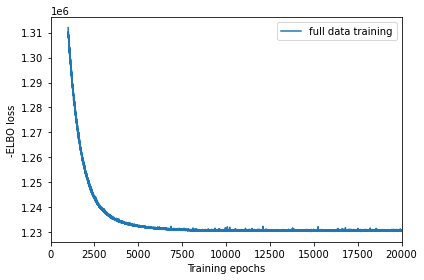

In [14]:
gc.collect()
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=6,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection (using default here):
    detection_alpha=200
)

mod.train(max_epochs=20000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [15]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

Sampling global variables, sample: 100%|████████████████████████████████████████████████████████| 999/999 [00:17<00:00, 57.38it/s]


In [16]:
# Save model
run_name = f'./results/analysis/cell2location_map'

mod.save(run_name, overwrite=True)
end_time = time.time()

In [17]:
# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file

/home/lih0n/anaconda3/envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
... storing 'sample' as categorical


'./results/analysis/cell2location_map/sp.h5ad'

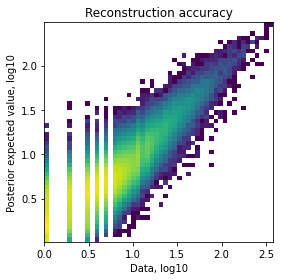

In [18]:
# Examine reconstruction accuracy to assess if there are any issues with mapping
# the plot should be roughly diagonal, strong deviations will signal problems
mod.plot_QC()

In [19]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']
result1 = adata_vis.obsm['q05_cell_abundance_w_sf']
result2 = adata_vis.obsm['q95_cell_abundance_w_sf']
result3 = adata_vis.obsm['means_cell_abundance_w_sf']
# result_mean = result3.to_csv('mean_gene_expressionhalfx.csv')
# result2.to_csv('95_gene_expressionhalfx.csv')
# result1.to_csv('05_gene_expressionhalfx.csv')

In [20]:
sum_result_3 = result3.sum(axis=1)
result3_percent = result3.div(result3.assign(total=sum_result_3)['total'], axis='index')
result_name = os.path.join(parent_path, "seqFISH_10000_Result", "Cell2location.csv")
result3_percent.to_csv(result_name)

In [21]:
sum_result_2 = result2.sum(axis=1)
result2_percent = result2.div(result2.assign(total=sum_result_2)['total'], axis='index')
result2_percent.to_csv('q95_gene_expression_test_SeqFISH_10000.csv')

In [22]:
sum_result_1 = result1.sum(axis=1)
result1_percent = result1.div(result1.assign(total=sum_result_1)['total'], axis='index')
result1_percent.to_csv('q05_gene_expression_test_SeqFISH_10000.csv')

In [23]:
print("Total time comsuption: seconds")
print(end_time - start_time)

Total time comsuption: seconds
2153.3392839431763


In [24]:
# stdata = pd.read_csv('stdata_MERFISH_20.csv', header=0, index_col=0)
# scdata = pd.read_csv('cellcount_MERFISH_20.csv', header=0, index_col=0)
# print(stdata.shape)
# print(scdata.shape)